In [1]:
# A bit of setup
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### Generating some data

Lets generate a classification dataset that is not easily linearly separable. Our favorite example is the spiral dataset, which can be generated as follows:

(-1, 1)

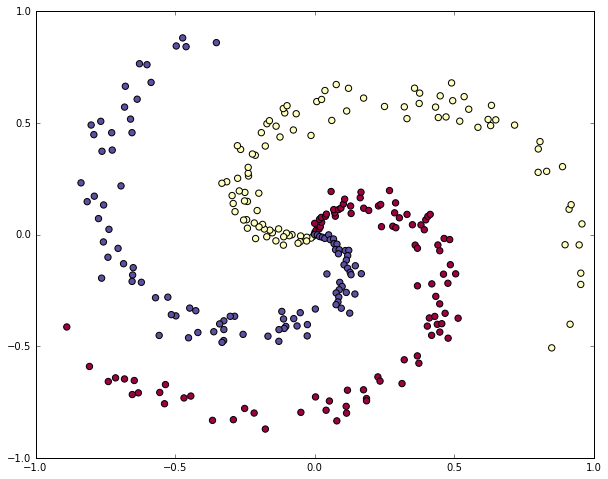

In [2]:
np.random.seed(0)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D))
y = np.zeros(N*K, dtype='uint8')
for j in xrange(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])
#fig.savefig('spiral_raw.png')

### Training a Softmax Linear Classifier

Lets first train a Softmax classifier on this classification dataset. The Softmax classifier has a linear score function and uses the cross-entropy loss. The parameters of the linear classifier consist of a weight matrix W and a bias vector b for each class. Lets first initialize these parameters to be random numbers.

In [3]:
#Train a Linear Classifier

# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

### Compute the class scores

Since this is a linear classifier, we can compute all class scores very simply in parallel with a single matrix multiplication.

In [4]:
# gradient descent loop
num_examples = X.shape[0]
for i in xrange(200):
  
  # evaluate class scores, [N x K]
  scores = np.dot(X, W) + b 
  
  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  


Given the array of scores we've computed above, we can compute the loss.


In [5]:
  # compute the loss: average cross-entropy loss and regularization
  corect_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(corect_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W)
  loss = data_loss + reg_loss
  if i % 10 == 0:
    print "iteration %d: loss %f" % (i, loss)

**probs** stores the probabilities of all classes (as rows) for each example. Get the gradient on the scores, which we call **dscores**.


In [6]:
  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples


Lastly, we had that scores = np.dot(X, W) + b, so armed with the gradient on scores (stored in dscores), we can now backpropagate into W and b.


In [7]:
  # backpropate the gradient to the parameters (W,b)
  dW = np.dot(X.T, dscores)
  db = np.sum(dscores, axis=0, keepdims=True)
  
  dW += reg*W # regularization gradient


Now that we've evaluated the gradient we know how every parameter influences the loss function. We will now perform a parameter update in the negative gradient direction to decrease the loss.



In [8]:
  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db


We see that we've converged to something after about 190 iterations. We can evaluate the training set accuracy.


In [9]:
# evaluate training set accuracy
scores = np.dot(X, W) + b
predicted_class = np.argmax(scores, axis=1)
print 'training accuracy: %.2f' % (np.mean(predicted_class == y))

training accuracy: 0.48



The training accuracy is not good, but also not surprising given that the dataset is constructed so it is not linearly separable. We plot the learned decision boundaries.


(-1.8712034092398278, 1.8687965907601756)

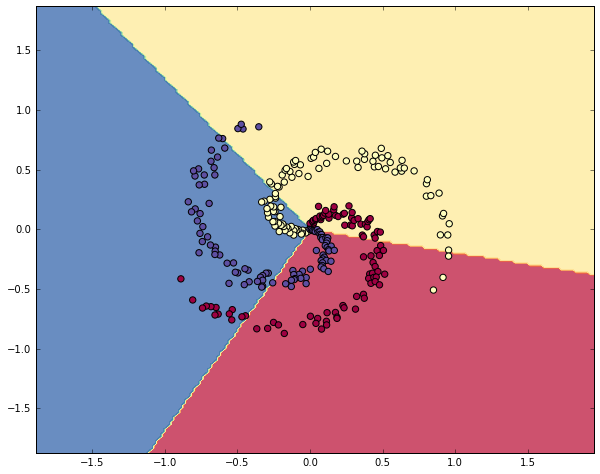

In [10]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_linear.png')

### Training a Neural Network

Clearly, a linear classifier is inadequate for this dataset and we would like to use a Neural Network. 
One additional hidden layer will suffice for this toy data. We will now need two sets of weights 
and biases (for the first and second layers).



In [11]:
# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in xrange(10000):
  
  # evaluate class scores, [N x K]
  hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
  scores = np.dot(hidden_layer, W2) + b2
  
  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
  # compute the loss: average cross-entropy loss and regularization
  corect_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(corect_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
  loss = data_loss + reg_loss
  if i % 1000 == 0:
    print "iteration %d: loss %f" % (i, loss)
  
  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples
  
  # backpropate the gradient to the parameters
  # first backprop into parameters W2 and b2
  dW2 = np.dot(hidden_layer.T, dscores)
  db2 = np.sum(dscores, axis=0, keepdims=True)
  # next backprop into hidden layer
  dhidden = np.dot(dscores, W2.T)
  # backprop the ReLU non-linearity
  dhidden[hidden_layer <= 0] = 0
  # finally into W,b
  dW = np.dot(X.T, dhidden)
  db = np.sum(dhidden, axis=0, keepdims=True)
  
  # add regularization gradient contribution
  dW2 += reg * W2
  dW += reg * W
  
  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db
  W2 += -step_size * dW2
  b2 += -step_size * db2

iteration 0: loss 1.098637
iteration 1000: loss 0.294416
iteration 2000: loss 0.266441
iteration 3000: loss 0.251507
iteration 4000: loss 0.248295
iteration 5000: loss 0.247107
iteration 6000: loss 0.246423
iteration 7000: loss 0.245958
iteration 8000: loss 0.245329
iteration 9000: loss 0.245068


In [12]:
# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print 'training accuracy: %.2f' % (np.mean(predicted_class == y))

training accuracy: 0.98


(-1.8712034092398278, 1.8687965907601756)

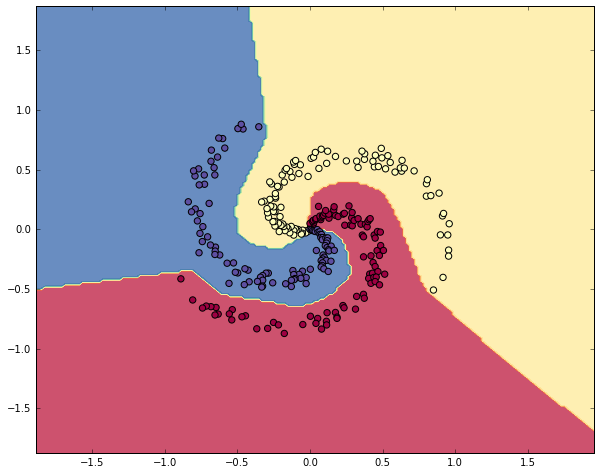

In [13]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_net.png')

### Summary

We've worked with a toy 2D dataset and trained both a linear network and a 2-layer Neural Network. We saw that the change from a linear classifier to a Neural Network involves very few changes in the code. The score function changes its form (1 line of code difference), and the backpropagation changes its form (we have to perform one more round of backprop through the hidden layer to the first layer of the network).